In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [4]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [5]:
def run():

    model_params = dict(conserve=None, Jx=1., Jy=1., Jz=1., L=2, verbose=1)
    prod_state = ["up", "up"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
        'mixer': False,  # setting this to True helps to escape local minima
#         'mixer': True,
#         'mixer_params': {
#             'amplitude': 1.e-5,
#             'decay': 1.2,
#             'disable_after': 30
#         },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-6,
        'max_sweeps': 150,
        'verbose': 1.,
    }
    
    
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    data = dict(entropy_list=[], correlation_list=[])
    chi_list = [4, 8, 16, 32, 64, 128]
    for chi in chi_list:
        
        print("=" * 100)
        print("Chi = ", chi, '\n')
        
#         eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        eng.run()
        
        print("Canonicalizing...")
        psi.canonical_form()
        
        print("Computing properties")
        entropy = np.mean(psi.entanglement_entropy())
        correlation = psi.correlation_length()

        data['entropy_list'].append(entropy)
        data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        pass
        
    return data


def plot_results(data):

    plt.figure()
    ax = plt.gca()
    ax.plot(data['ent_spectrum'], marker='o')
    ax.set_xlabel(r"DMRG Step")
    ax.set_ylabel(r"$ E $")
    plt.savefig("KitaevLadderModel.pdf")


In [6]:
data = run()
# plot_results(data)
print(data)

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=2 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=1.0 for KitaevLadderModel
parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
Chi =  4 

parameter 'max_sweeps'=150 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=False for Sweep
Updating environment
.....
sweep 10, age = 408
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 117.3 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
Updating environment
.....
sweep 20, age = 648
Energy = -0.1250000000000000, S = 0.00000000000

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3673: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


Updating environment
.....
sweep 10, age = 888
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
Updating environment
.....
sweep 20, age = 1128
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 3.9 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
DMRG finished after 20 sweeps.
total size = 1128, maximum chi = 1
Canonicalizing...
Computing properties
Optimizing
Chi =  16 



/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3673: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


Updating environment
.....
sweep 10, age = 1368
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
Updating environment
.....
sweep 20, age = 1608
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 3.7 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
DMRG finished after 20 sweeps.
total size = 1608, maximum chi = 1
Canonicalizing...
Computing properties
Optimizing
Chi =  32 



/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3673: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


Updating environment
.....
sweep 10, age = 1848
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 1.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
Updating environment
.....
sweep 20, age = 2088
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 3.7 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
DMRG finished after 20 sweeps.
total size = 2088, maximum chi = 1
Canonicalizing...
Computing properties
Optimizing
Chi =  64 



/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3673: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


Updating environment
.....
sweep 10, age = 2328
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
Updating environment
.....
sweep 20, age = 2568
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 3.7 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
DMRG finished after 20 sweeps.
total size = 2568, maximum chi = 1
Canonicalizing...
Computing properties
Optimizing
Chi =  128 



/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3673: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


Updating environment
.....
sweep 10, age = 2808
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
Updating environment
.....
sweep 20, age = 3048
Energy = -0.1250000000000000, S = 0.0000000000000000, norm_err = 0.0e+00
Current memory usage 118.3 MB, time elapsed: 3.7 s
Delta E = 0.0000e+00, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 0.0000e+00
MPS bond dimensions: [1, 1, 1, 1, 1, 1, 1, 1]
DMRG finished after 20 sweeps.
total size = 3048, maximum chi = 1
Canonicalizing...
Computing properties
Optimizing
{'entropy_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'correlation_list': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:3673: UserWarning: trimming speigs k to smaller matrix dimension d
  eta, A = speigs(flat_linop, k=k, which='LM', **kwargs)


/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


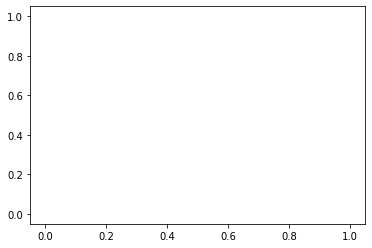

In [7]:
entropy_list = data['entropy_list'][2:-1]
correlation_list = data['correlation_list'][2:-1]
plt.plot(np.log(correlation_list), entropy_list, 'o')

In [8]:
from scipy.optimize import curve_fit

def func(xi, c, a):
    return (c / 6) * np.log(xi) + a

In [9]:
xi = correlation_list
log_xi = np.log(correlation_list)
s = entropy_list
fitParams, fitCovariances = curve_fit(func, xi, s)

/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/jerry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/jerry/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [10]:
fitCovariances

array([[inf, inf],
       [inf, inf]])

In [11]:
2**4

16

In [12]:
type(2**4)

int